In [1]:
import awkward as ak
import uproot
import hist
import jax
import numpy as np

In [2]:
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

In [3]:
events = uproot.open("data/HiggsZZ4mu.root:Events")
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))
MET_pt               | float                    | AsDtype('>f4')
MET_phi              | float                    | AsDtype('>f4')
nGenPart             | uint32_t                 | AsDtype('>u4')
GenPart_

In [4]:
muons = events.arrays(
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"},
    array_cache=None,
)
muons = ak._v2.tmp_for_testing.v1_to_v2(muons.layout)
muons = ak._v2.values_astype(ak._v2.Array(muons, backend="jax"), np.float64)
tan = ak._v2.ones_like(muons)

In [59]:
import random
params = ak._v2.Array({"param1": ak._v2.full_like(muons.pt, random.uniform(0.0, ak._v2.min(muons.pt))),
                       "param2": ak._v2.full_like(muons.pt, random.uniform(0.0, ak._v2.min(muons.pt)))})
# params.append(ak._v2.full_like(muons.pt, random.uniform(0.0, ak._v2.min(muons.pt))))
# params.append(ak._v2.full_like(muons.pt, random.uniform(0.0, ak._v2.min(muons.pt))))

def calibrate_muons(muons, calib_params):
    muons.pt= (muons.pt - calib_params["param1"]) * calib_params["param2"]
    return muons


In [60]:
def f(muons):
    cut = (ak._v2.num(muons.charge) >= 2) & (ak._v2.sum(muons.charge[:, :2], axis=1) == 0)
    mu1, mu2 = muons[cut][:, 0], muons[cut][:, 1]
    return np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi)))

In [61]:
def analysis(muons, calib_params):
    calib_muons = calibrate_muons(muons, calib_params)
    return f(calib_muons)

analyis(muons, params)

<Array [36.91503422529658, ..., 68.30598247012703] type='123800 * float64'>

In [65]:
val, tangent_func = jax.vjp(analysis, muons, params)
print(primals)
tan_muons, tan_params = tangent_func(val)
print(tan_muons)
print(tan_params)

[36.91503422529658, 88.44340044298309, ..., 68.30598247012703]
[{pt: [], eta: [], phi: [], charge: []}, ..., {pt: [...], eta: [...], ...}]
[{param1: [], param2: []}, {...}, ..., {param1: [0.0, ..., 0.0], param2: [...]}]


In [49]:
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h1 = hist.Hist.new.Reg(120, 0, 120, name="derivative(f)").Double()

In [50]:
vjp_val, vjp_func = jax.vjp(f, muons)

In [52]:
primals, tangent = jax.jvp(f, (muons,), (tan,)) 

In [53]:
h1.fill(tangent)
h.fill(f(muons))

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double()) # Sum: 123753.0 (123800.0 with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fb48ea09540>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

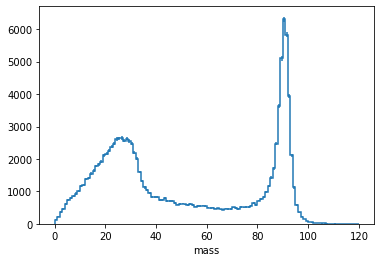

In [54]:
h.plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fb48c93cfd0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

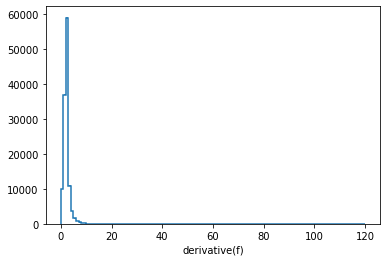

In [55]:
h1.plot()